In [ ]:
from google.colab import files
files.upload()

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
!kaggle datasets download -d veeralakrishna/200-bird-species-with-11788-images

100% 1.11G/1.11G [00:11<00:00, 66.2MB/s]
100% 1.11G/1.11G [00:11<00:00, 106MB/s] 


In [ ]:
!mkdir Dataset
!cp /content/200-bird-species-with-11788-images.zip
!unzip -q /content/200-bird-species-with-11788-images.zip -d /content/Dataset
!rm /content/200-bird-species-with-11788-images.zip

cp: missing destination file operand after '/content/200-bird-species-with-11788-images.zip'
Try 'cp --help' for more information.


In [ ]:
!mkdir Dataset/Images
!tar -xvzf /content/Dataset/CUB_200_2011.tgz -C /content/Dataset/
!rm /content/Dataset/CUB_200_2011.tgz

Streaming output truncated to the last 5000 lines.
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0050_111087.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0079_113288.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0004_111989.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0068_113247.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0127_111935.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0094_112773.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0028_113217.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0126_110959.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0007_111029.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0096_111519.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0120_113001.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0010_112678.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0025_111669.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0084_111300.j

In [ ]:
import numpy as np
import pandas as pd
import copy
import time
from tqdm import tqdm
import os

import torch
import torchvision
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.utils.data import DataLoader, sampler, random_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
def get_classes(data_dir):
  all_data = datasets.ImageFolder(data_dir)
  return all_data.classes

def get_data_loaders(data_dir, batch_size, train = False):
  if train:
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.1),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.RandomErasing(p=0.25, value='random')
    ])
    all_data = datasets.ImageFolder(data_dir, transform = transform)
    train_data_len = int(len(all_data)*0.75)
    valid_data_len = int((len(all_data)-train_data_len)/2)
    test_data_len = int(len(all_data)-train_data_len-valid_data_len)
    train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle = True, num_workers=4)
    return train_loader, train_data_len
  else:
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    all_data = datasets.ImageFolder(data_dir, transform = transform)
    train_data_len = int(len(all_data)*0.70)
    valid_data_len = int((len(all_data)-train_data_len)/2)
    test_data_len = int(len(all_data)-train_data_len-valid_data_len)
    train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle = True, num_workers=4)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle = True, num_workers=4)
    return (val_loader, test_loader, valid_data_len, test_data_len)

In [ ]:
dataset_path = "/content/Dataset/CUB_200_2011/images"
(train_loader, train_data_len) = get_data_loaders(dataset_path, 256, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 64, train=False)
classes = get_classes(dataset_path)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
dataloaders = {
    "train":train_loader,
    "val":val_loader
}
dataset_sizes = {
    "train":train_data_len,
    "val":valid_data_len
}

In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

35
28
28


In [ ]:
print(train_data_len, test_data_len, valid_data_len)

8841 1769 1768


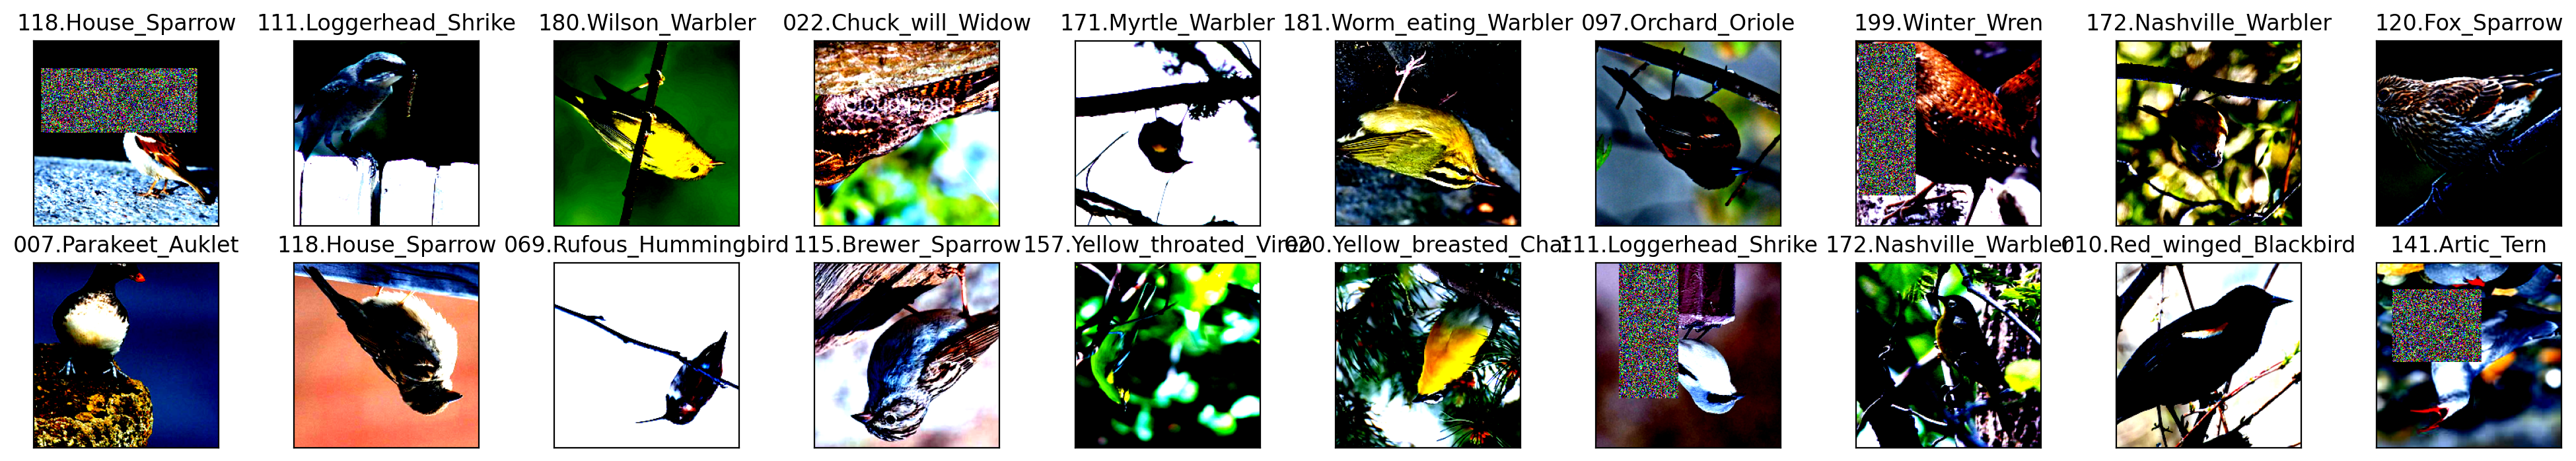

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize = (25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, int(20/2), idx+1, xticks = [], yticks = [])
  plt.imshow(np.transpose(images[idx], (1,2,0)))
  ax.set_title(classes[labels[idx]])

In [ ]:
torch.backends.cudnn.benchmark = True
model = torchvision.models.efficientnet_b0(pretrained = True)

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
for param in model.parameters():
  param.requires_grad = False

n_inputs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(n_inputs, len(classes))
'''model.classifier = nn.Sequential(
    #nn.Linear(n_inputs, 1028),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1028, len(classes))
)'''
device = 'cuda'
model = model.to(device)
print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=200, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
criterion = criterion.to('cuda')
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001)

step_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma = 0.96)

training_history = {'accuracy':[], 'loss':[]}
validation_history = {'accuracy':[], 'loss':[]}

In [ ]:
def train_model(model, criterion, optimizer,scheduler, num_epochs=25):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-'*10)

    for phase in ['train', 'val']:
      if phase=='train':
        model.train()
      else:
        model.eval()
      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in tqdm(dataloaders[phase]):
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase=='train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase=='train':
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds==labels.data)
      if phase=='train':
        scheduler.step()

      epoch_loss = running_loss/dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      if phase=='train':
        training_history['accuracy'].append(epoch_acc)
        training_history['loss'].append(epoch_loss)
      elif phase=='val':
        validation_history['accuracy'].append(epoch_acc)
        validation_history['loss'].append(epoch_loss)
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      if phase=='val' and epoch_acc>best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    print()
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
  print('Best val Acc: {:4f}'.format(best_acc))
  model.load_state_dict(best_model_wts)
  return model

In [ ]:
model_ft = train_model(model, criterion, optimizer, step_scheduler, num_epochs=16)

Epoch 0/15
----------


100%|██████████| 35/35 [01:25<00:00,  2.43s/it]


train Loss: 4.9270 Acc: 0.1421


100%|██████████| 28/28 [00:17<00:00,  1.61it/s]


val Loss: 4.2655 Acc: 0.4949

Epoch 1/15
----------


100%|██████████| 35/35 [01:19<00:00,  2.27s/it]


train Loss: 4.1126 Acc: 0.4489


100%|██████████| 28/28 [00:15<00:00,  1.80it/s]


val Loss: 3.5991 Acc: 0.6137

Epoch 2/15
----------


100%|██████████| 35/35 [01:20<00:00,  2.31s/it]


train Loss: 3.6268 Acc: 0.5433


100%|██████████| 28/28 [00:15<00:00,  1.81it/s]


val Loss: 3.1982 Acc: 0.6844

Epoch 3/15
----------


100%|██████████| 35/35 [01:22<00:00,  2.35s/it]


train Loss: 3.3216 Acc: 0.6028


100%|██████████| 28/28 [00:16<00:00,  1.71it/s]


val Loss: 2.9448 Acc: 0.7257

Epoch 4/15
----------


100%|██████████| 35/35 [01:25<00:00,  2.44s/it]


train Loss: 3.1221 Acc: 0.6490


100%|██████████| 28/28 [00:16<00:00,  1.70it/s]


val Loss: 2.7994 Acc: 0.7506

Epoch 5/15
----------


100%|██████████| 35/35 [01:33<00:00,  2.67s/it]


train Loss: 2.9907 Acc: 0.6796


100%|██████████| 28/28 [00:15<00:00,  1.79it/s]


val Loss: 2.6986 Acc: 0.7670

Epoch 6/15
----------


100%|██████████| 35/35 [01:29<00:00,  2.56s/it]


train Loss: 2.9009 Acc: 0.6964


100%|██████████| 28/28 [00:15<00:00,  1.80it/s]


val Loss: 2.6260 Acc: 0.7743

Epoch 7/15
----------


100%|██████████| 35/35 [01:22<00:00,  2.36s/it]


train Loss: 2.8165 Acc: 0.7241


100%|██████████| 28/28 [00:15<00:00,  1.80it/s]


val Loss: 2.5647 Acc: 0.7964

Epoch 8/15
----------


100%|██████████| 35/35 [01:21<00:00,  2.34s/it]


train Loss: 2.7654 Acc: 0.7357


100%|██████████| 28/28 [00:15<00:00,  1.80it/s]


val Loss: 2.5220 Acc: 0.8111

Epoch 9/15
----------


100%|██████████| 35/35 [01:30<00:00,  2.57s/it]


train Loss: 2.7114 Acc: 0.7547


100%|██████████| 28/28 [00:15<00:00,  1.80it/s]


val Loss: 2.4798 Acc: 0.8162

Epoch 10/15
----------


100%|██████████| 35/35 [01:33<00:00,  2.66s/it]


train Loss: 2.6683 Acc: 0.7663


100%|██████████| 28/28 [00:15<00:00,  1.79it/s]


val Loss: 2.4508 Acc: 0.8224

Epoch 11/15
----------


100%|██████████| 35/35 [01:21<00:00,  2.33s/it]


train Loss: 2.6356 Acc: 0.7757


100%|██████████| 28/28 [00:15<00:00,  1.80it/s]


val Loss: 2.4259 Acc: 0.8314

Epoch 12/15
----------


100%|██████████| 35/35 [01:22<00:00,  2.35s/it]


train Loss: 2.6009 Acc: 0.7859


100%|██████████| 28/28 [00:15<00:00,  1.81it/s]


val Loss: 2.4014 Acc: 0.8450

Epoch 13/15
----------


100%|██████████| 35/35 [01:21<00:00,  2.32s/it]


train Loss: 2.5674 Acc: 0.8010


100%|██████████| 28/28 [00:15<00:00,  1.80it/s]


val Loss: 2.3823 Acc: 0.8450

Epoch 14/15
----------


100%|██████████| 35/35 [01:21<00:00,  2.32s/it]


train Loss: 2.5445 Acc: 0.8065


100%|██████████| 28/28 [00:15<00:00,  1.80it/s]


val Loss: 2.3649 Acc: 0.8495

Epoch 15/15
----------


100%|██████████| 35/35 [01:20<00:00,  2.31s/it]


train Loss: 2.5225 Acc: 0.8195


100%|██████████| 28/28 [00:15<00:00,  1.78it/s]

val Loss: 2.3452 Acc: 0.8541

Training complete in 26m 44s
Best val Acc: 0.854072


In [ ]:
from PIL import Image
import requests
from io import BytesIO


def apply_test_transforms(image):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    return transform(image)

def predict(model, filepath, show_img = False, url=False):
  if url:
    response = requests.get(filepath)
    im = Image.open(BytesIO(response.content))
  else:
    im = Image.open(filepath)
  if show_img:
    plt.imshow(im)
  im_as_tensor = apply_test_transforms(im)
  minibatch = torch.stack([im_as_tensor])
  if torch.cuda.is_available():
    minibatch = minibatch.cuda()
  pred = model(minibatch)
  _, classnum = torch.max(pred, 1)
  print(classnum)
  return classes[classnum]

def formatText(string):
  string = string[4:]
  string = string.replace("-", " ")
  return string

tensor([95], device='cuda:0')


'Hooded_Oriole'

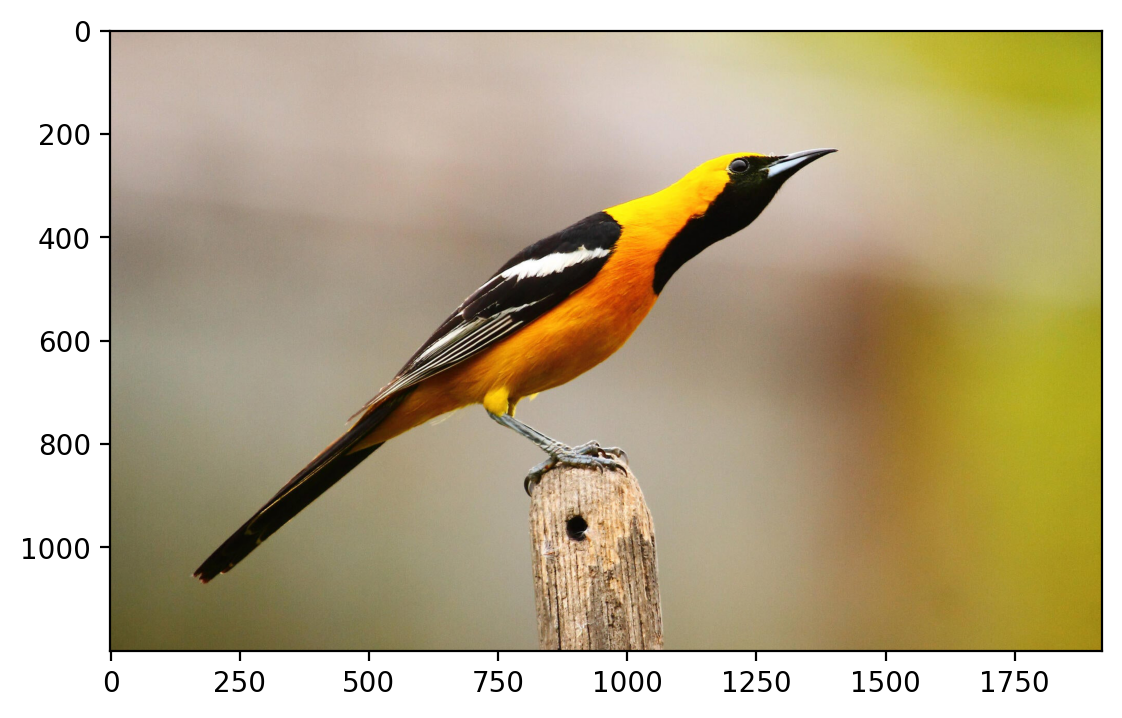

In [ ]:
formatText(predict(model_ft, "https://media.audubon.org/nas_birdapi/h_a1_3726_1_hooded-oriole_leonard_hantz_kk_adult-male.jpg", show_img=True, url=True))

In [ ]:
torch.save(model_ft.state_dict(), '/content/Dataset/CUB_200_2011/model1_using_torch_save.pth')

In [ ]:
torch.save(model_ft.state_dict(), '/content/Dataset/CUB_200_2011/model2_using_torch_save.pt')

In [ ]:
x = torch.randn(1, 3, 224, 224, requires_grad=False)
example = torch.rand(1, 3, 224, 224)

traced_script_module = torch.jit.trace(model_ft.cpu(), example)

traced_script_module.save("/content/Dataset/CUB_200_2011/cub2011-deit-tiny.zip")
traced_script_module.save("/content/Dataset/CUB_200_2011/model3_with_zip.h5")
traced_script_module.save("/content/Dataset/CUB_200_2011/model4_with_zip.pt")

In [ ]:
x = torch.randn(1, 3, 224, 224, requires_grad=False).to('cuda')
example = torch.rand(1, 3, 224, 224)

traced_script_module = torch.jit.trace(model_ft.cpu(), example)

traced_script_module.save("/content/Dataset/CUB_200_2011/cub2011-deit-tiny_cuda.zip")
traced_script_module.save("/content/Dataset/CUB_200_2011/model5_with_zip_cuda.h5")
traced_script_module.save("/content/Dataset/CUB_200_2011/model6_with_zip_cuda.pt")

In [50]:
def predict1(model, filepath, show_img = False, url=False):
  if url:
    response = requests.get(filepath)
    im = Image.open(BytesIO(response.content))
  else:
    im = Image.open(filepath)
  if show_img:
    plt.imshow(im)
  im_as_tensor = apply_test_transforms(im)
  minibatch = torch.stack([im_as_tensor])
  '''if torch.cuda.is_available():
    minibatch = minibatch.cuda()'''
  pred = model(minibatch)
  _, classnum = torch.max(pred, 1)
  print(classnum)
  return classes[classnum]

tensor([95])


'Hooded_Oriole'

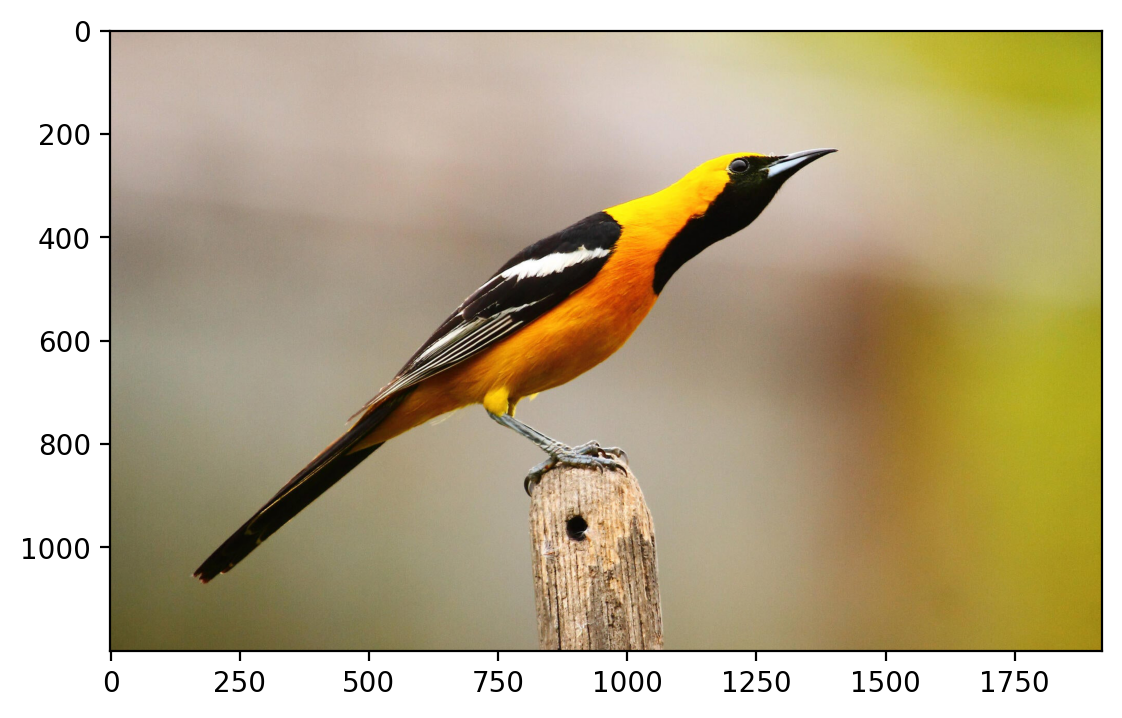

In [55]:
loaded_model = torch.jit.load("/content/Dataset/CUB_200_2011/model3_with_zip.h5")
#loaded_model = loaded_model.to('cpu')  # Move the loaded model to the CPU

formatText(predict1(loaded_model, "https://media.audubon.org/nas_birdapi/h_a1_3726_1_hooded-oriole_leonard_hantz_kk_adult-male.jpg", show_img=True, url=True))

In [54]:
print(classes)

['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet', '006.Least_Auklet', '007.Parakeet_Auklet', '008.Rhinoceros_Auklet', '009.Brewer_Blackbird', '010.Red_winged_Blackbird', '011.Rusty_Blackbird', '012.Yellow_headed_Blackbird', '013.Bobolink', '014.Indigo_Bunting', '015.Lazuli_Bunting', '016.Painted_Bunting', '017.Cardinal', '018.Spotted_Catbird', '019.Gray_Catbird', '020.Yellow_breasted_Chat', '021.Eastern_Towhee', '022.Chuck_will_Widow', '023.Brandt_Cormorant', '024.Red_faced_Cormorant', '025.Pelagic_Cormorant', '026.Bronzed_Cowbird', '027.Shiny_Cowbird', '028.Brown_Creeper', '029.American_Crow', '030.Fish_Crow', '031.Black_billed_Cuckoo', '032.Mangrove_Cuckoo', '033.Yellow_billed_Cuckoo', '034.Gray_crowned_Rosy_Finch', '035.Purple_Finch', '036.Northern_Flicker', '037.Acadian_Flycatcher', '038.Great_Crested_Flycatcher', '039.Least_Flycatcher', '040.Olive_sided_Flycatcher', '041.Scissor_tailed_Flycatcher', '042.Ver